### Langevin Equation

Equation (1)
$$ \gamma \dot{x_1} = -V^\prime _1 (x_1) - k_1 x_2 + \sqrt{2k_B T_1 \gamma}ξ_1 $$
$$ \gamma \dot{x_2} = -V^\prime _2 (x_2) - k_2 x_1 + \sqrt{2k_B T_2 \gamma}ξ_2 $$

$$ V_1 (x_1) = \frac{a_1}{2} x_1^2, V_2 (x_2) = \frac{a_2}{2} x_2^2 $$

Equation (2)

$$ \dot{x_1} = -\frac{a_1}{\gamma} x_1 - \frac{k_1}{\gamma} x_2 + \sqrt{\frac{2k_B T_1}{\gamma}}ξ_1 $$
$$ \dot{x_2} = -\frac{a_2}{\gamma} x_2 - \frac{k_2}{\gamma} x_1 + \sqrt{\frac{2k_B T_2}{\gamma}}ξ_2 $$

### Stochastic Heat:

$$ 0 = - \gamma \dot{x_1} + \sqrt{2k_B T_1 \gamma}ξ_1 - V^\prime _1 (x_1) - k_1 x_2  $$
$$ 0 = - \gamma \dot{x_2} + \sqrt{2k_B T_2 \gamma}ξ_2 - V^\prime _2 (x_2) - k_2 x_1  $$

For x_1:

$$ \delta Q_1 = (-\gamma \dot{x_1} + \sqrt{2k_B T_1 \gamma}ξ_1) \circ dx_1  = (V^\prime _1 (x_1) + k_1 x_2) \circ dx_1$$

$$ \delta Q_1 = (a_1 x_1 + k_1 x_2) \circ dx_1  $$

For x_2:

$$ \delta Q_2 = (-\gamma \dot{x_2} + \sqrt{2k_B T_2 \gamma}ξ_2) \circ dx_2  = (V^\prime _2 (x_2) + k_2 x_1) \circ dx_2$$

$$ \delta Q_2 = (a_2 x_2 + k_2 x_1) \circ dx_2  $$

### Functions for euler method

Euler Scheme

$$ X_{t+\Delta t} = X_t + f(X_t, t)\Delta t + g(X_t,t)\Delta B_t $$

where $$ \Delta B_t = \mathcal{N}(0, \sqrt\Delta t) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm

In [2]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x1 = 0
    x2 = 0
    x1_traj = []
    x2_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x1, x2
        x1_new = x1 - (pars['a1']/pars['gamma'])*x1*pars['delta_t'] - \
        (pars['k1']/pars['gamma'])*x2*pars['delta_t'] + \
        np.sqrt((2*pars['Kb']*pars['T1'])/pars['gamma'])*s1
                 
        x2_new = x2 - (pars['a2']/pars['gamma'])*x2*pars['delta_t'] - \
        (pars['k2']/pars['gamma'])*x1*pars['delta_t'] + \
        np.sqrt((2*pars['Kb']*pars['T2'])/pars['gamma'])*s2
                
        x1 = x1_new
        x2 = x2_new
        
        x1_traj.append(x1)
        x2_traj.append(x2)
    return x1_traj, x2_traj

### Functions for stochastic heat

Equation (3):

$$ \delta Q_1 = (a_1 x_1 + k_1 x_2) \circ dx_1  $$

$$ \delta Q_2 = (a_2 x_2 + k_2 x_1) \circ dx_2  $$

In [3]:
def calc_stochastic_heat_q1(x1, x2, pars):
    """Calculates stochastic heat per time delta following equation (3)
    Input:
    x1 (list) = x1_trajectory_list
    x2 (list) = x2_trajectory_list
    pars (dictionary) = parameters
    
    Here's an example:
    x1 =       [1,2,3,4,5]
    x1_shift = [5,1,2,3,4]
    Then we can easily calculate operations, e.g. dx1 = x1 - x1_ shift
    Vectorization (technique of implementing array operations without using for loop) is easier.
    
    After which, we discard the first element
    
    Returns:
    stochastic heat as shown in equation (3)"""
    x1_shift = np.roll(x1, shift = 1)   
    x2_shift = np.roll(x2, shift = 1)
    
    first_term = pars['a1']*((x1 + x1_shift)/2)
    second_term = pars['k1']*((x2 + x2_shift)/2)
    dx1 = x1 - x1_shift
    return (first_term[1:] + second_term[1:])*dx1[1:]

def calc_stochastic_heat_q2(x1, x2, pars):
    x1_shift = np.roll(x1, shift = 1)   
    x2_shift = np.roll(x2, shift = 1)    
    
    first_term = pars['a2']*((x2 + x2_shift)/2)
    second_term = pars['k2']*((x1 + x1_shift)/2)
    dx2 = x2 - x2_shift
    return (second_term[1:] + first_term[1:])*dx2[1:]

In [4]:
#function to calculate average q (cumulative_heat) after performing n_realizations
def average_q(max1_time, pars):
    min_time = 0
    n_time = int((max1_time - min_time)/pars['delta_t'] + 1) #n_time = num of evenlx2 spaced samples (ex1. 1001 points)
    time = np.linspace(min_time, max1_time, n_time) #time(ex1. 0 (min time), 0.01, 0.02, ..., 10 (max1 time)) with n_time no. of data points
    
    average_q1_trajectorx2 = 0
    average_q2_trajectorx2 = 0
    for i in range(pars['n_realizations']):
        x1_traj, x2_traj = euler_one_traj(n_time, pars)
        q1_trajectorx2 = calc_stochastic_heat_q1(x1_traj, x2_traj, pars)
        q1_cumulative = np.cumsum(q1_trajectorx2)
        
        q2_trajectorx2 = calc_stochastic_heat_q2(x1_traj, x2_traj, pars)
        q2_cumulative = np.cumsum(q2_trajectorx2)
        
        average_q1_trajectorx2 += q1_cumulative/pars['n_realizations']
        average_q2_trajectorx2 += q2_cumulative/pars['n_realizations']
        
    return average_q1_trajectorx2, average_q2_trajectorx2, time[:-1]

In [5]:
#plot stochastic heat
def stochastic_heat_plotter(q1, q2, y_range, pars):
    mean_q1 = np.mean(q1)
    std_q1 = np.std(q1)
    mean_q2 = np.mean(q2)
    std_q2 = np.std(q2)

    plt.figure(figsize=(10,4))
    plt.plot(time, q1, label = 'q1')
    plt.plot(time, q2, alpha = 0.5, label = 'q2')
    plt.title('q1: Mean: {:.3g} and Std Dev: {:.3g} \n q2: Mean: {:.3g} and Std Dev: {:.3g}'.format(mean_q1, std_q1, mean_q2, std_q2))

    plt.suptitle('T1: {}, T2: {}'.format(pars['T1'], pars['T2']))
    plt.xlabel('time')
    plt.ylabel('stochastic heat')
    
    plt.ylim(y_range)

    plt.legend()

    plt.tight_layout()
    plt.show()

### Start here

In [6]:
#paramaters
pars = {}
pars['a1'] = 1
pars['k1'] = 0.5
pars['T1'] = 100
pars['a2'] = 1
pars['k2'] = 0.5
pars['T2'] = 100

pars['gamma'] = 1
pars['delta_t'] = 0.01
pars['Kb'] = 1.380649*10**-23

Plotting T1 = T2

In [7]:
%%time
pars['T1'] = 100
pars['T2'] = 100
pars['n_realizations'] = 100
q1_eq, q2_eq, time = average_q(300, pars)

# y_range = [-5*10**-9, 10*10**-9]
# stochastic_heat_plotter(q1_eq, q2_eq, y_range, pars)

Wall time: 40.4 s


Setting T2 > T1

In [8]:
pars['T1'] = 100
pars['T2'] = 600
pars['n_realizations'] = 100
q1_neq, q2_neq, time = average_q(300, pars)

# y_range = [-8*10**-7, 8*10**-7]
# stochastic_heat_plotter(q1_neq, q2_neq, y_range, pars)

### Plotting average cumulative heat 

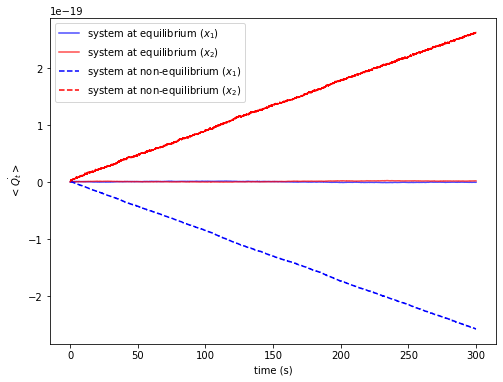

In [22]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(time, q1_eq, color = 'blue', alpha = 0.7, label = 'system at equilibrium ($x_1$)')
ax.plot(time, q2_eq, color = 'red', alpha = 0.7, label= 'system at equilibrium ($x_2$)')
ax.plot(time, q1_neq, color = 'blue', linestyle='dashed', label = 'system at non-equilibrium ($x_1$)')
ax.plot(time, q2_neq, color = 'red',  linestyle='dashed', label= 'system at non-equilibrium ($x_2$)')

plt.xlabel('time (s)')
plt.ylabel('$<\dot{Q_t}>$')
plt.legend()
plt.savefig('stoch_heat.png', dpi=300)
plt.show()